In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [32]:
# class KNN:
#     def __init__(self,k=5):
#         self.k=k
    
#     def fit(self,x_train,y_train):
#         self.x_train=x_train
#         self.y_train=y_train
    
#     def predict(self, x_test):
#         return np.array([self._predict(x) for x in x_test])
    
#     def _predict(self,x):
#         distances=np.linalg.norm(self.x_train-x,axis=1)  
#         k_indices=np.argsort(distances)[:self.k] 
#         k_nearest_labels=self.y_train[k_indices]
#         unique_labels,counts=np.unique(k_nearest_labels,return_counts=True)
#         most_common_label=unique_labels[np.argmax(counts)]
#         return most_common_label

In [33]:
# def cross_validate_knn(x,y,k_values,folds=5):
#     skf = StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)
#     results={}

#     total_iterations=len(k_values)*folds
#     iteration=1 
#     for k in k_values:
#         accuracies=[]
#         print(f"\nTesting K={k}:||:")

#         for fold,(train_idx,val_idx) in enumerate(skf.split(x,y),start=1):
#             print(f"Fold {fold}/{folds} (Iteration {iteration}/{total_iterations})")
#             iteration+=1  
#             x_train,x_val=x[train_idx],x[val_idx]
#             y_train,y_val=y[train_idx],y[val_idx]

#             knn=KNN(k=k)
#             knn.fit(x_train,y_train)
#             y_pred=knn.predict(x_val)
            
#             acc=accuracy_score(y_val,y_pred)
#             accuracies.append(acc)

#         results[k]=np.mean(accuracies)
#         print(f"K={k}, Mean Accuracy={results[k]:.4f}")

#     print("\nCross-validation completed!")
#     return results


In [34]:
df = pd.read_csv("cleaned.csv")
x = df.drop(columns=["Diabetes_012"]).values
y = df["Diabetes_012"].astype(int).values 

In [35]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [36]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [37]:
# k_values=range(1,21)  
# cross_val=cross_validate_knn(x_train,y_train,k_values)

In [38]:
# best_k=max(cross_val,key=cross_val.get)
# print(f"\nBest K found: {best_k} with accuracy: {cross_val[best_k]:.4f}")

In [39]:
# best_knn=KNN(k=best_k)
# best_knn.fit(x_train,y_train)
# y_pred=best_knn.predict(x_test)

In [40]:
# final_accuracy=accuracy_score(y_test,y_pred)
# print(f"Final KNN Accuracy with K={best_k}: {final_accuracy:.4f}")

In [41]:
# plt.figure(figsize=(8, 5))
# plt.plot(k_values,list(cross_val.values()),marker='o',linestyle='dashed')
# plt.xlabel("K Value")
# plt.ylabel("Mean Cross-Validation Accuracy")
# plt.title("Optimal K Selection using Cross-Validation")
# plt.grid(True)
# plt.show()

# Gpu

In [42]:
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, accuracy_score


In [43]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class KNN:
    def __init__(self,k=5):
        self.k=k
        self.x_train=None
        self.y_train=None

    def fit(self,x_train,y_train):
        self.x_train=torch.tensor(x_train,dtype=torch.float32,device=device)  
        self.y_train=torch.tensor(y_train,dtype=torch.int64,device=device)  

    def predict(self,x_test):
        x_test=torch.tensor(x_test,dtype=torch.float32,device=device)  
        dists=torch.cdist(x_test,self.x_train)
        knn_indices=torch.topk(dists,self.k,largest=False).indices
        knn_labels=self.y_train[knn_indices]
        unique_labels,counts=torch.mode(knn_labels,dim=1)  
        return unique_labels.cpu().numpy()  
    
    def predict_proba(self, x_test):
        x_test=torch.tensor(x_test,dtype=torch.float32,device=device)  
        dists=torch.cdist(x_test,self.x_train)
        knn_indices=torch.topk(dists, self.k, largest=False).indices
        knn_labels=self.y_train[knn_indices]
        
        probas=[]
        for i in range(knn_labels.shape[0]):
            label_counts=torch.bincount(knn_labels[i],minlength=3)
            probas.append(label_counts.float()/self.k)
        return torch.stack(probas).cpu().numpy()

def cross_validate_KNN(x,y,k_values,folds=5):
    skf=StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)
    results={}

    tot_iteration=len(k_values)*folds
    i=1

    for k in k_values:
        accuracies=[]
        print(f"\nTesting K={k} on GPU...")

        for fold,(train_idx,val_idx) in enumerate(skf.split(x,y),start=1):
            print(f"Fold {fold}/{folds}(Iteration {i}/{tot_iteration})")
            i+=1
            x_train,x_val=x[train_idx],x[val_idx]
            y_train,y_val=y[train_idx],y[val_idx]
            knn=KNN(k=k)
            knn.fit(x_train,y_train)
            y_pred=knn.predict(x_val)
            acc=accuracy_score(y_val,y_pred)
            accuracies.append(acc)

        results[k]=np.mean(accuracies)
        print(f"K={k}, Mean Accuracy={results[k]:.4f}")

    return results

In [45]:

k_values=range(1,21)  
results=cross_validate_KNN(x_train,y_train,k_values)
best_k=max(results,key=results.get)
print("Best K:",max(results,key=results.get))


best_knn=KNN(k=best_k)
best_knn.fit(x_train,y_train)  
y_pred=best_knn.predict(x_test)

final_accuracy=accuracy_score(y_test,y_pred)*100 
print(f"Final KNN Accuracy with K={best_k}: {final_accuracy:.4f} %")


Testing K=1 on GPU...
Fold 1/5(Iteration 1/100)
Fold 2/5(Iteration 2/100)
Fold 3/5(Iteration 3/100)
Fold 4/5(Iteration 4/100)
Fold 5/5(Iteration 5/100)
K=1, Mean Accuracy=0.6799

Testing K=2 on GPU...
Fold 1/5(Iteration 6/100)
Fold 2/5(Iteration 7/100)
Fold 3/5(Iteration 8/100)
Fold 4/5(Iteration 9/100)
Fold 5/5(Iteration 10/100)
K=2, Mean Accuracy=0.6971

Testing K=3 on GPU...
Fold 1/5(Iteration 11/100)
Fold 2/5(Iteration 12/100)
Fold 3/5(Iteration 13/100)
Fold 4/5(Iteration 14/100)
Fold 5/5(Iteration 15/100)
K=3, Mean Accuracy=0.7089

Testing K=4 on GPU...
Fold 1/5(Iteration 16/100)
Fold 2/5(Iteration 17/100)
Fold 3/5(Iteration 18/100)
Fold 4/5(Iteration 19/100)
Fold 5/5(Iteration 20/100)
K=4, Mean Accuracy=0.7111

Testing K=5 on GPU...
Fold 1/5(Iteration 21/100)
Fold 2/5(Iteration 22/100)
Fold 3/5(Iteration 23/100)
Fold 4/5(Iteration 24/100)
Fold 5/5(Iteration 25/100)
K=5, Mean Accuracy=0.7139

Testing K=6 on GPU...
Fold 1/5(Iteration 26/100)
Fold 2/5(Iteration 27/100)
Fold 3/5(Ite

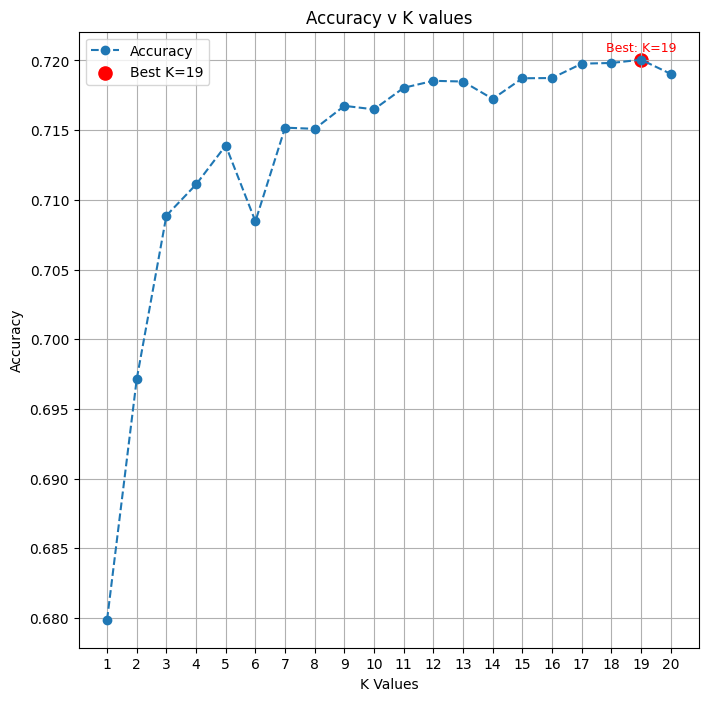

In [46]:
plt.figure(figsize=(8,8))
plt.plot(k_values, list(results.values()), marker='o', linestyle='dashed', label="Accuracy")

best_k = max(results, key=results.get)
best_acc = results[best_k]

plt.scatter(best_k, best_acc, color='red', s=90, label=f"Best K={best_k}")  
plt.annotate(f"\nBest: K={best_k}", 
             (best_k, best_acc), 
             textcoords="offset points", 
             xytext=(0,6), 
             ha='center', 
             fontsize=9, 
             color='red')

plt.xlabel("K Values")
plt.ylabel("Accuracy")
plt.title("Accuracy v K values")

plt.xticks(range(min(k_values), max(k_values) + 1))

plt.legend()
plt.grid(True)
plt.show()


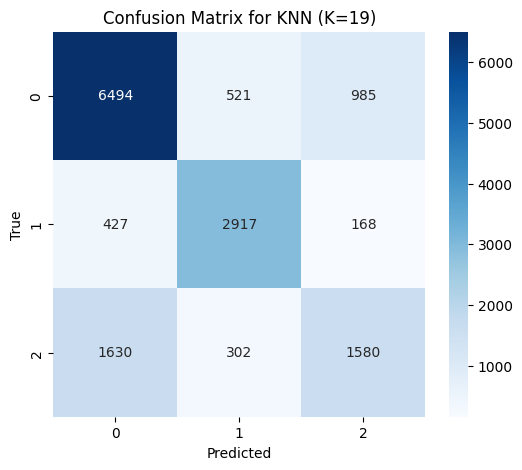

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_knn = KNN(k=best_k)
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for KNN (K={best_k})')
plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

def cross_validate_KNN_with_metrics(x, y, k_values, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    results = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1': {}}

    tot_iteration = len(k_values) * folds
    i = 1

    best_k = None
    best_accuracy = -1  

    for k in k_values:
        accuracies, precisions, recalls, f1_scores = [], [], [], []
        print(f"\nTesting K={k}...")

        for fold, (train_idx, val_idx) in enumerate(skf.split(x, y), start=1):
            print(f"Fold {fold}/{folds}(i {i}/{tot_iteration})")
            i += 1
            x_train, x_val = x[train_idx], x[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            knn = KNN(k=k)
            knn.fit(x_train, y_train)
            y_pred = knn.predict(x_val)

            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average='weighted')
            recall = recall_score(y_val, y_pred, average='weighted')
            f1 = f1_score(y_val, y_pred, average='weighted')

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        mean_accuracy = np.mean(accuracies)
        results['accuracy'][k] = mean_accuracy
        results['precision'][k] = np.mean(precisions)
        results['recall'][k] = np.mean(recalls)
        results['f1'][k] = np.mean(f1_scores)

        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k

    print(f"\nBest K={best_k}:")
    print(f"  Accuracy: {results['accuracy'][best_k]:.4f}")
    print(f"  Precision: {results['precision'][best_k]:.4f}")
    print(f"  Recall: {results['recall'][best_k]:.4f}")
    print(f"  F1 Score: {results['f1'][best_k]:.4f}")

    return best_k, results

k_values = range(1, 21)
best_k, results = cross_validate_KNN_with_metrics(x_train, y_train, k_values)

best_knn = KNN(k=best_k)
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)

final_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nFinal KNN Accuracy with K={best_k}: {final_accuracy:.4f} %")



Testing K=1...
Fold 1/5(i 1/100)
Fold 2/5(i 2/100)
Fold 3/5(i 3/100)
Fold 4/5(i 4/100)
Fold 5/5(i 5/100)

Testing K=2...
Fold 1/5(i 6/100)
Fold 2/5(i 7/100)
Fold 3/5(i 8/100)
Fold 4/5(i 9/100)
Fold 5/5(i 10/100)

Testing K=3...
Fold 1/5(i 11/100)
Fold 2/5(i 12/100)
Fold 3/5(i 13/100)
Fold 4/5(i 14/100)
Fold 5/5(i 15/100)

Testing K=4...
Fold 1/5(i 16/100)
Fold 2/5(i 17/100)
Fold 3/5(i 18/100)
Fold 4/5(i 19/100)
Fold 5/5(i 20/100)

Testing K=5...
Fold 1/5(i 21/100)
Fold 2/5(i 22/100)
Fold 3/5(i 23/100)
Fold 4/5(i 24/100)
Fold 5/5(i 25/100)

Testing K=6...
Fold 1/5(i 26/100)
Fold 2/5(i 27/100)
Fold 3/5(i 28/100)
Fold 4/5(i 29/100)
Fold 5/5(i 30/100)

Testing K=7...
Fold 1/5(i 31/100)
Fold 2/5(i 32/100)
Fold 3/5(i 33/100)
Fold 4/5(i 34/100)
Fold 5/5(i 35/100)

Testing K=8...
Fold 1/5(i 36/100)
Fold 2/5(i 37/100)
Fold 3/5(i 38/100)
Fold 4/5(i 39/100)
Fold 5/5(i 40/100)

Testing K=9...
Fold 1/5(i 41/100)
Fold 2/5(i 42/100)
Fold 3/5(i 43/100)
Fold 4/5(i 44/100)
Fold 5/5(i 45/100)

Testing K

In [49]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print("Classification Report for KNN:\n")
print(report)


Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      8000
           1       0.78      0.83      0.80      3512
           2       0.58      0.45      0.51      3512

    accuracy                           0.73     15024
   macro avg       0.71      0.70      0.70     15024
weighted avg       0.72      0.73      0.72     15024



In [ ]:
class KNN:
    def __init__(self,k=5):
        self.k=k
        self.x_train=None
        self.y_train=None

    def fit(self,x_train,y_train):
        self.x_train=torch.tensor(x_train,dtype=torch.float32,device=device)  
        self.y_train=torch.tensor(y_train,dtype=torch.int64,device=device)  

    def predict(self,x_test):
        x_test=torch.tensor(x_test,dtype=torch.float32,device=device)  
        dists=torch.cdist(x_test,self.x_train)
        knn_indices=torch.topk(dists,self.k,largest=False).indices
        knn_labels=self.y_train[knn_indices]
        unique_labels,counts=torch.mode(knn_labels,dim=1)  
        return unique_labels.cpu().numpy()  
    
    def predict_proba(self, x_test):
        x_test = torch.tensor(x_test, dtype=torch.float32, device=device)  
        
        dists = torch.cdist(x_test, self.x_train)
        knn_indices = torch.topk(dists, self.k, largest=False).indices
        knn_labels = self.y_train[knn_indices]
        
        probas = []
        for i in range(knn_labels.shape[0]):
            label_counts = torch.bincount(knn_labels[i], minlength=3)  
            probas.append(label_counts.float() / self.k)
        
        return torch.stack(probas).cpu().numpy()

def cross_validate_KNN(x,y,k_values,folds=5):
    skf=StratifiedKFold(n_splits=folds,shuffle=True,random_state=42)
    results={}

    tot_iteration=len(k_values)*folds
    i=1

    for k in k_values:
        accuracies=[]
        print(f"\nTesting K={k} on GPU...")

        for fold,(train_idx,val_idx) in enumerate(skf.split(x,y),start=1):
            print(f"Fold {fold}/{folds}(Iteration {i}/{tot_iteration})")
            i+=1
            x_train,x_val=x[train_idx],x[val_idx]
            y_train,y_val=y[train_idx],y[val_idx]

            knn=KNN(k=k)
            knn.fit(x_train,y_train)
            y_pred=knn.predict(x_val)

            acc=accuracy_score(y_val,y_pred)
            accuracies.append(acc)

        results[k]=np.mean(accuracies)
        print(f"K={k}, Mean Accuracy={results[k]:.4f}")

    return results

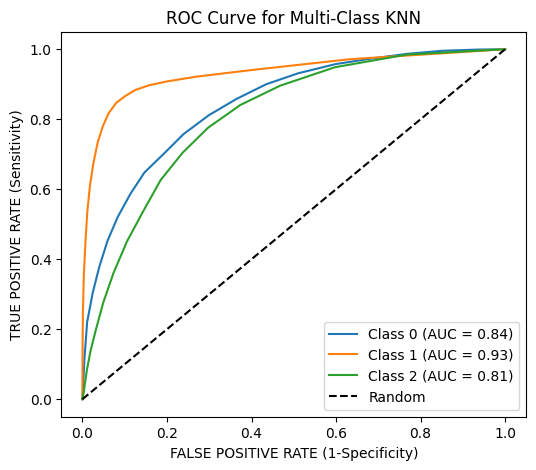

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curve(y_test, y_prob, classes=[0, 1, 2]):
    y_test_bin = label_binarize(y_test, classes=classes)
    
    plt.figure(figsize=(6, 5))

    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    plt.xlabel('FALSE POSITIVE RATE (1-Specificity)')
    plt.ylabel('TRUE POSITIVE RATE (Sensitivity)')
    plt.title('ROC Curve for Multi-Class KNN')
    plt.legend(loc='lower right')
    plt.show()

best_knn=KNN(k=best_k)
best_knn.fit(x_train,y_train)
y_prob=best_knn.predict_proba(x_test)
plot_roc_curve(y_test,y_prob)
